In [2]:
#Load the relevant modules and set up environment

from __future__ import division, print_function
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_style()
import dixoncoles as d 
import pandas as pd 
import numpy as np
%matplotlib inline

data,teams = d.load_and_preprocess();

# Extending Dixon & Coles

In this notebook, I will explore a simple extension to the Dixon & Coles model. In 1997, when the original paper was written, data on football matches was considerably more difficult to obtain. Consequently, the model produced by Dixon & Coles utilises only the most basic facts about a football match: the number of goals scored by either team. Today, however, a huge range of facts and statistics about each match are openly available. Here, I will describe how to extend the Dixon & Coles model to include the number of shots on target as well as the number of goals scored by each team.

In [2]:
data.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomeST,AwayST,BookiesHomeWin,BookiesDraw,BookiesAwayWin,Gameweek
Date,,,,,,,,,,
2015-08-08,0,10,0,1,2,3,0.500000,0.277778,0.250000,1
2015-08-08,1,13,2,2,3,10,0.735294,0.200000,0.090909,1
2015-08-08,2,15,2,2,5,5,0.588235,0.256410,0.181818,1
2015-08-08,3,12,4,2,8,5,0.512821,0.285714,0.230947,1
2015-08-08,4,14,1,0,1,4,0.606061,0.250000,0.166667,1


The data table I've constructed is very similar to the previous notebook. We are still looking at the Premier League (PL) season 2015/16, but there are now two extra columns: 'HomeST' and 'AwayST'. These quantify the number of goals scored by the home team and the away team, respectively. Let's look at how these are distributed.

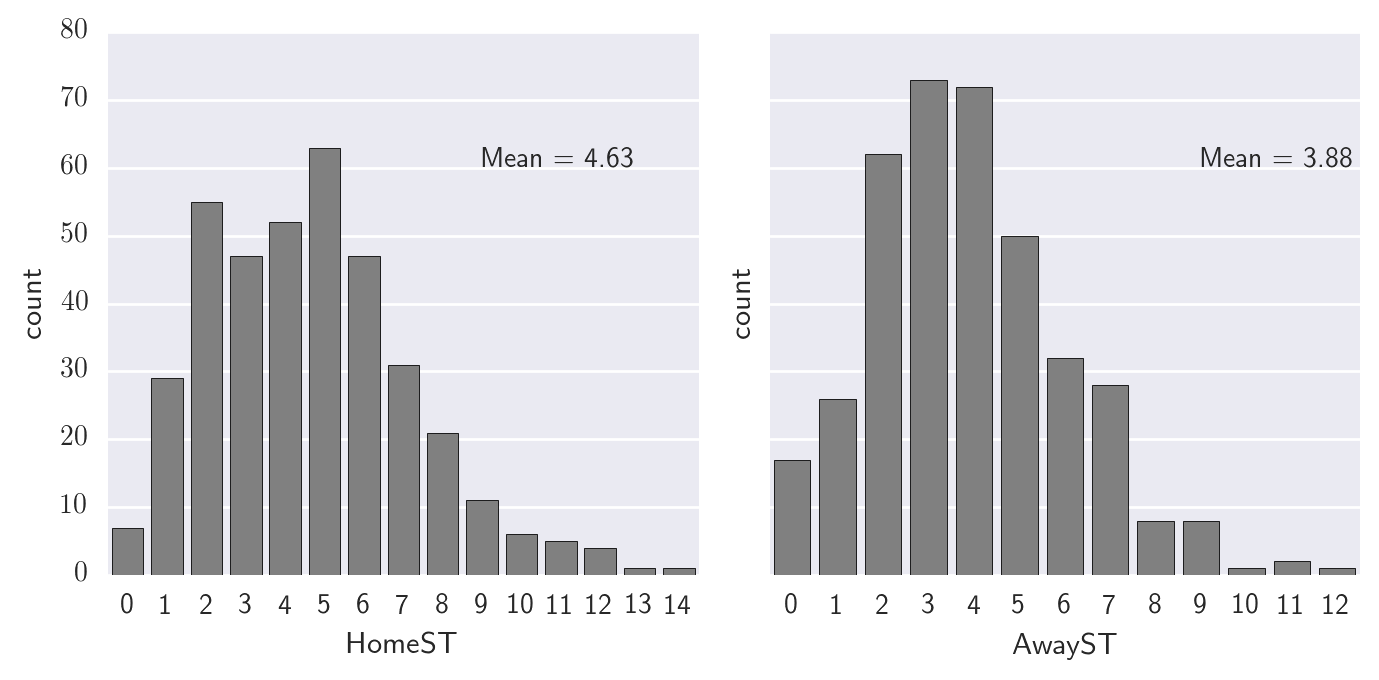

In [6]:
fig,ax = plt.subplots(1,2,figsize=(7,3.5),sharey=True)
sns.countplot(data['HomeST'],ax=ax[0],color='0.5')
sns.countplot(data['AwayST'],ax=ax[1],color='0.5')
ax[0].text(9,60,"Mean = {0:.2f}".format(data['HomeST'].mean()))
ax[1].text(9,60,"Mean = {0:.2f}".format(data['AwayST'].mean()));

The first important thing to note about these figures is that shots on target are a lot more common than goals. Obviously there must be at least as many shots on target as there are goals per team, but the mean number of shots on target is roughly three times as large as the number of goals scored. It is very rare that either team fails to achieve a single shot on target, whereas we saw previously that the away team are quite likely not to score any goals.

Ultimately, the new model should still produce probabilties for the outcomes of football matches. So, how should we incorporate the new data? My simple approach is to model the distribution of shots on target for either team as independent Poisson distributions, with rates parameterised in an identical way to the Dixon & Coles model:

`Q ~ Poisson(alpha_home * beta_away * gamma)`

`R ~ Poisson(alpha_away * beta_home)`,

where `Q` is the number of shots on target achieved by the home team, and `R` is the number achieved by the away team.
Then, I model the probability of either side scoring a goal as a binomial distribution, so that 

`X | Q ~ Binomial(epsilon_home)`

`Y | R ~ Binomial(epsilon_away)`.

In other words, the probability of the home team scoring `X` goals given that they achieved `Q` shots on target is a binomial distribution with a success probability of `epsilon_home`, and likewise for the away team. Thus, the new model contains 61 parameters: 20 `alpha` parameters, which quantify the propensity of each team to create chances, 20 `beta` parameters, which quantify how well a team defends, 20 `epsilon` parameters, which quantify how efficient teams are at converting shots on target into goals, and one `gamma` parameter that represents home advantage (we can see that home teams typically achieve roughly one more shot than the away team).

First, I'll fit the model to the PL season using the sliding window model from the previous notebook. Inspection of the parameters will give some intuition on the parameters.

In [4]:
alpha,beta,epsilon,gamma = d.fit_model_season(data,model='shots',window=20)
alpha = pd.DataFrame(alpha).rename(columns=lambda x: teams[x])
beta = pd.DataFrame(beta).rename(columns=lambda x: teams[x])
epsilon = pd.DataFrame(epsilon).rename(columns=lambda x: teams[x]);

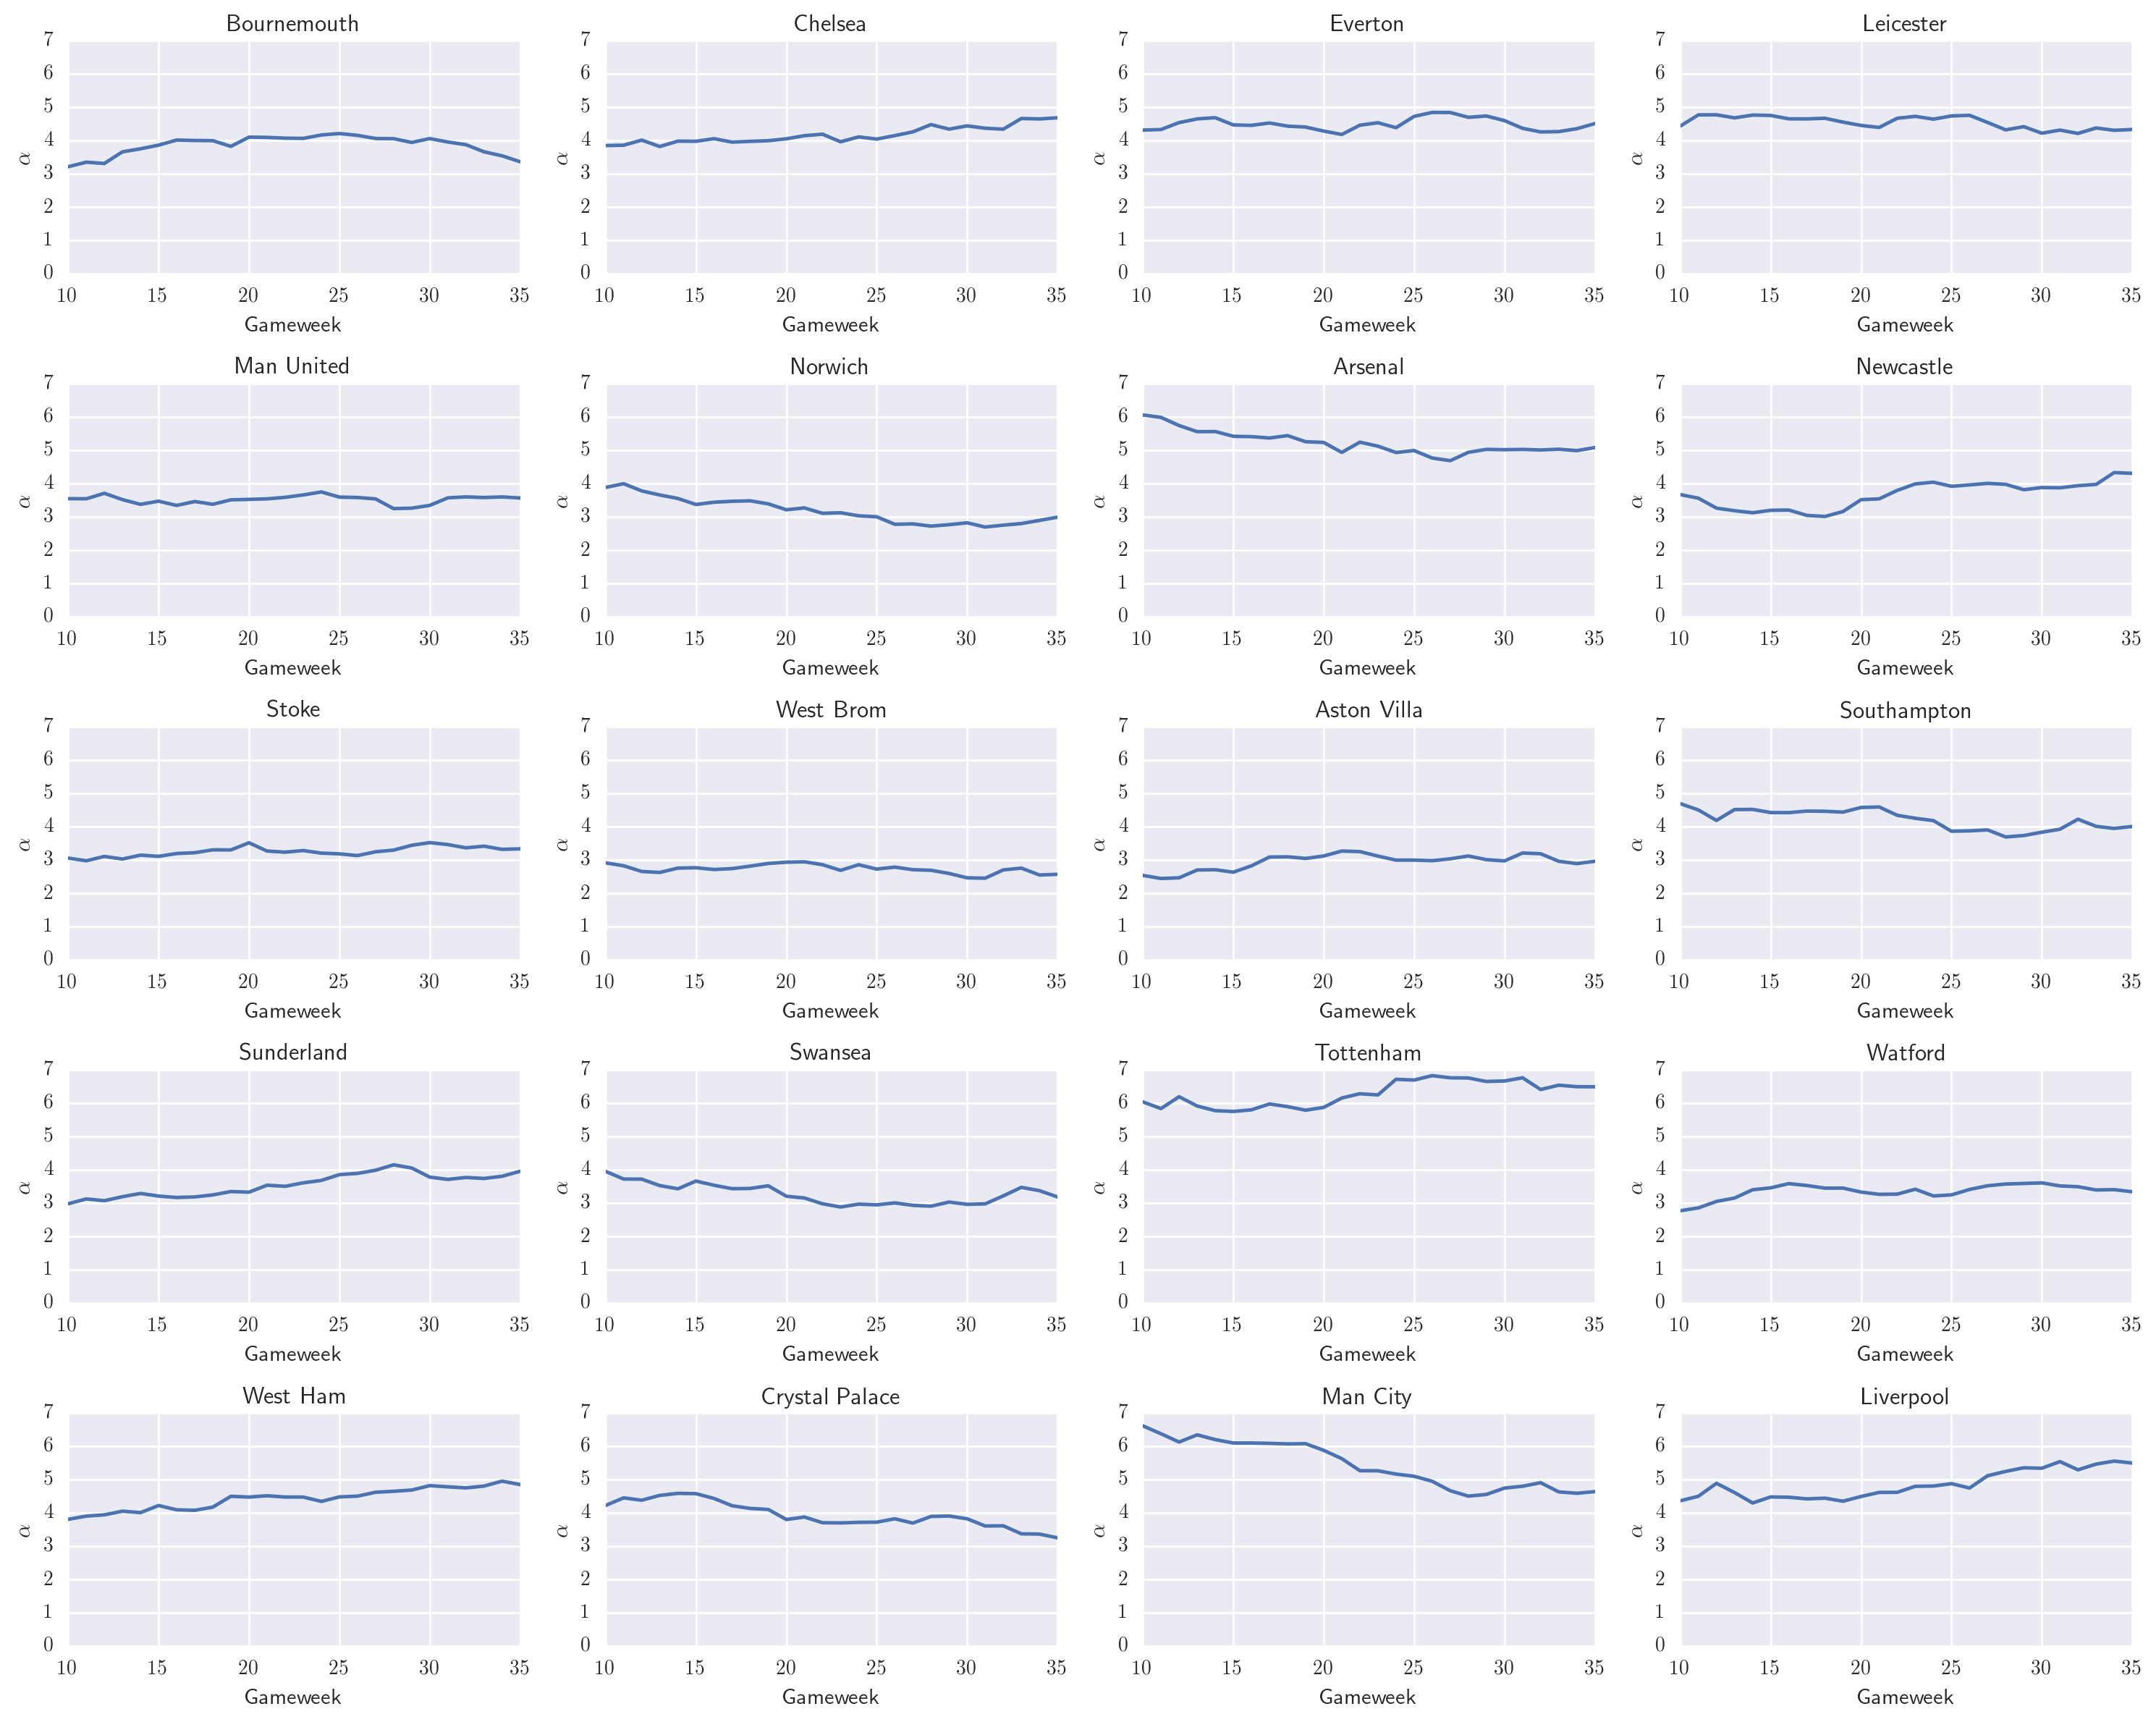

In [17]:
mean_beta = np.mean(beta.as_matrix())
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(mean_beta*alpha[team][10:])
    np.ravel(ax)[i].set_ylim((0.,7))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\alpha$");

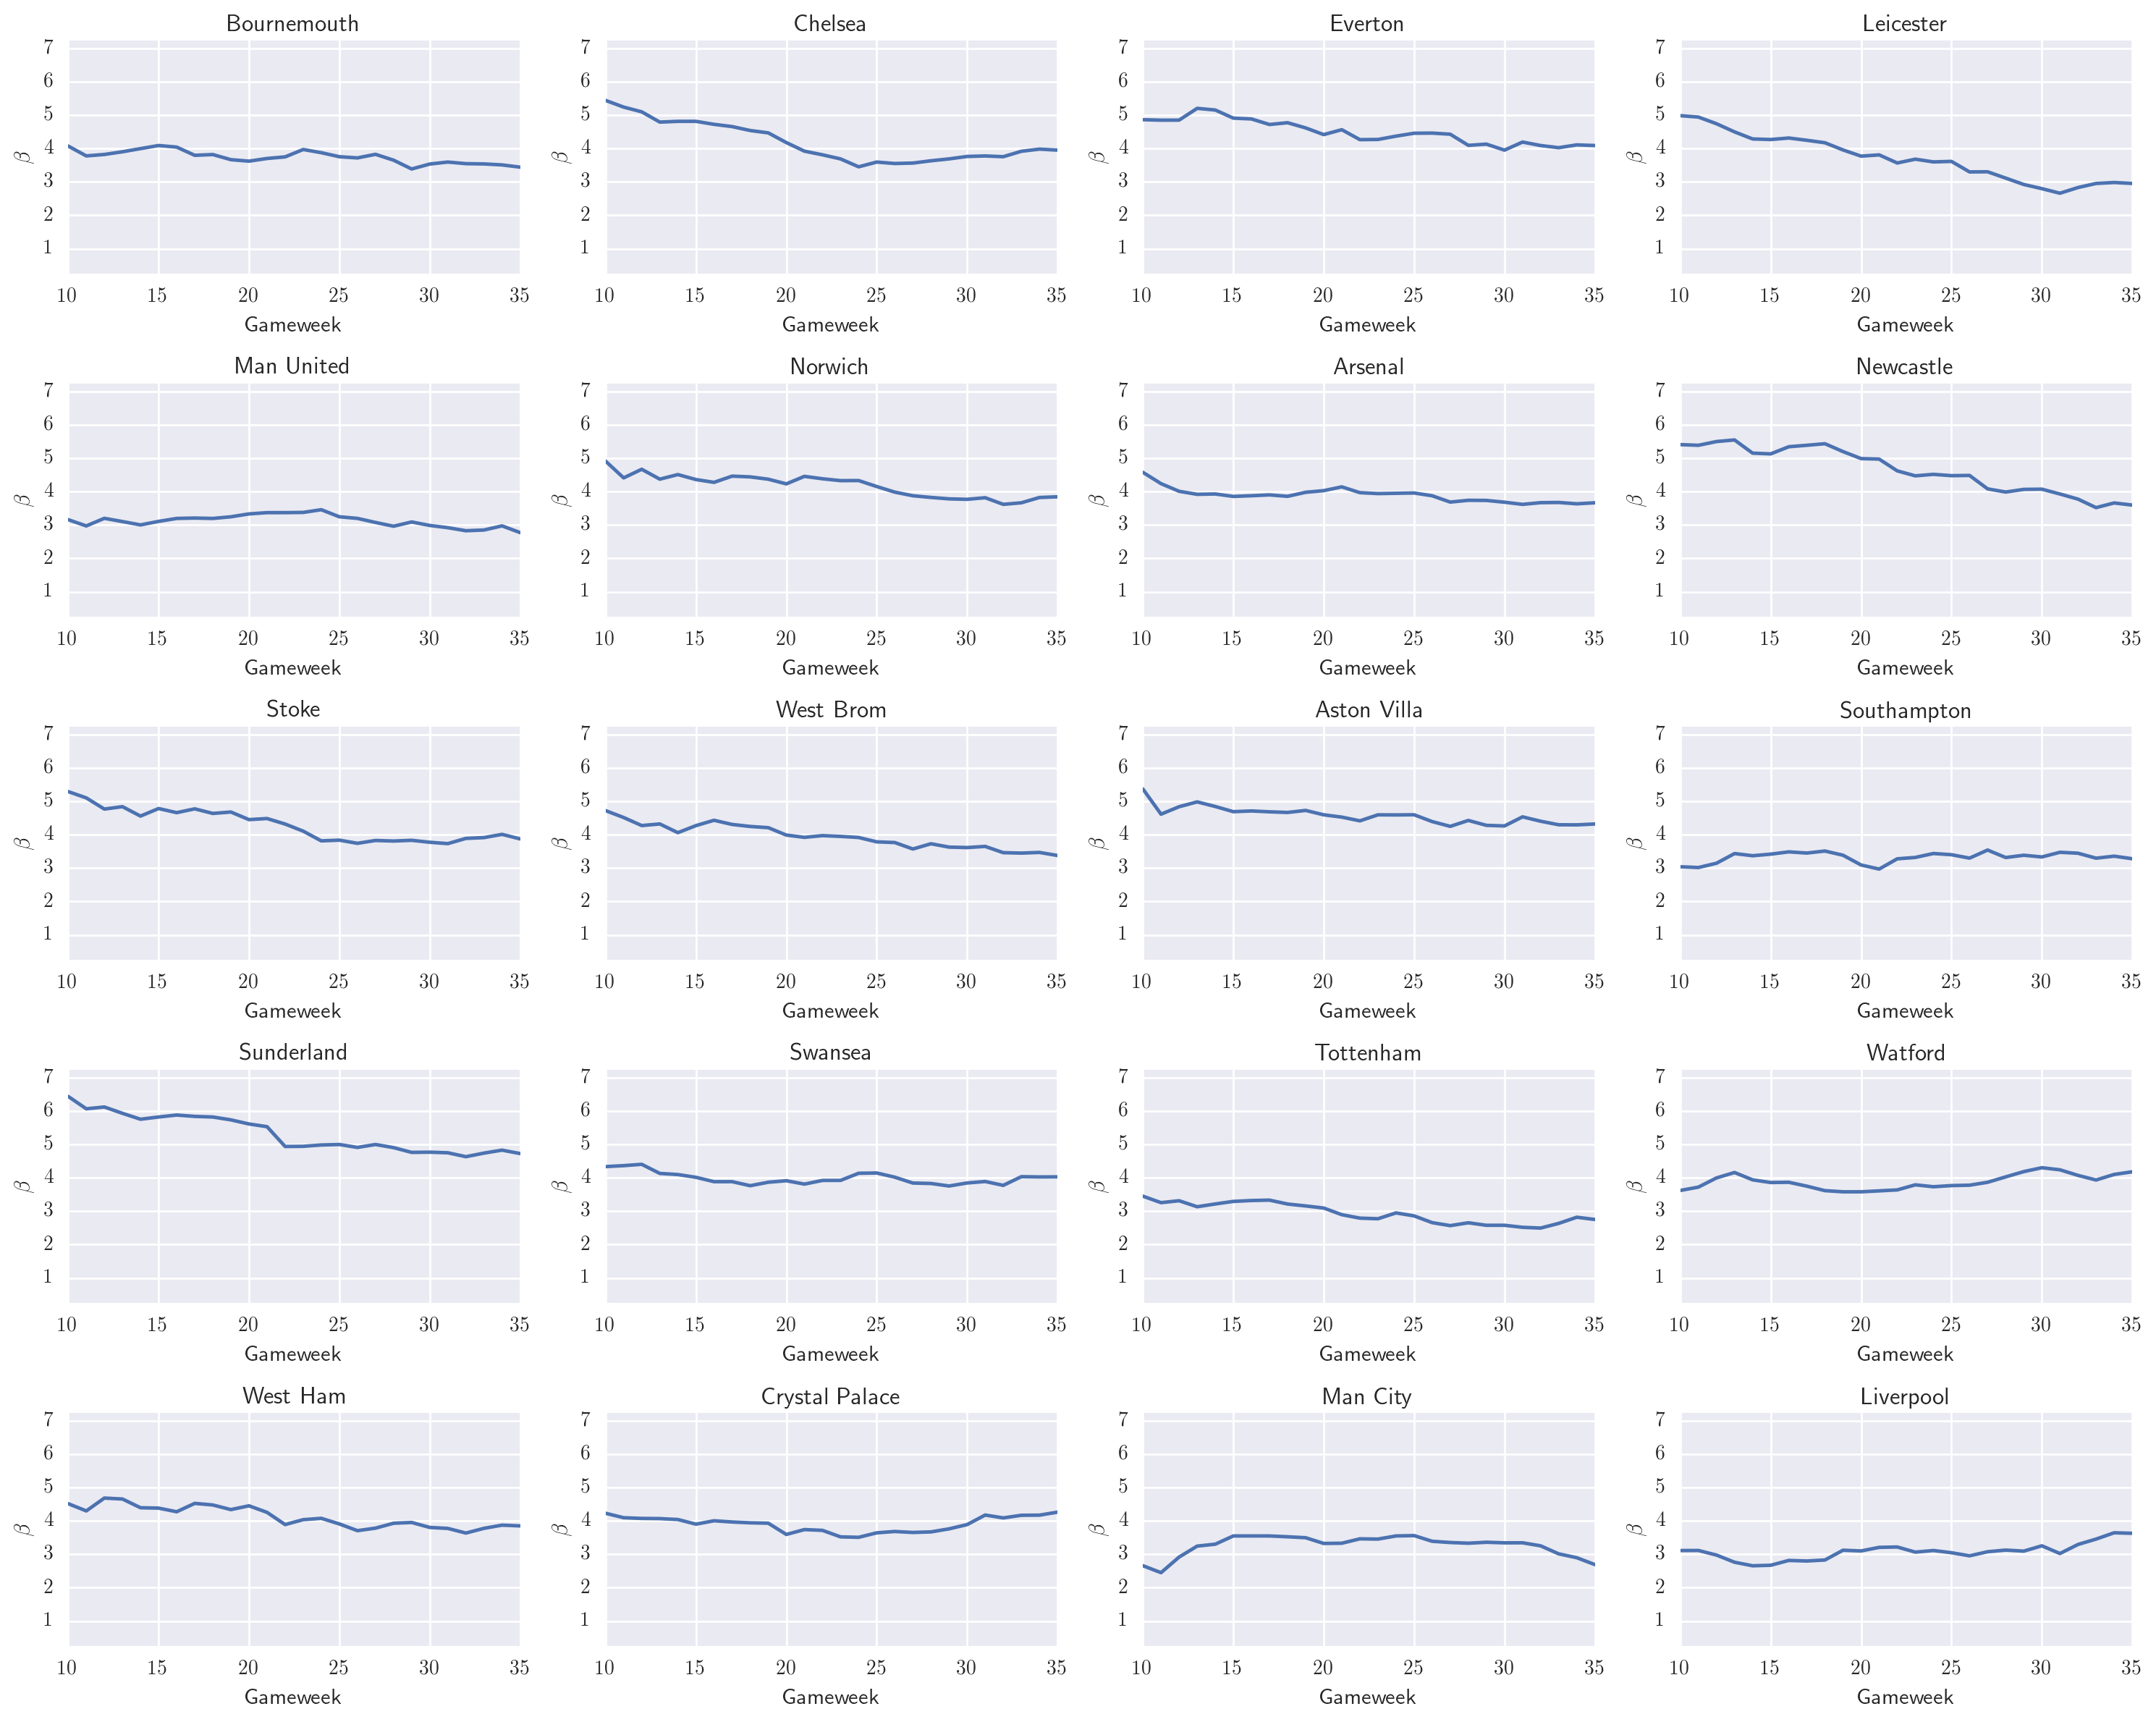

In [9]:
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(beta[team][10:])
    np.ravel(ax)[i].set_ylim((0.,7.))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\beta$");

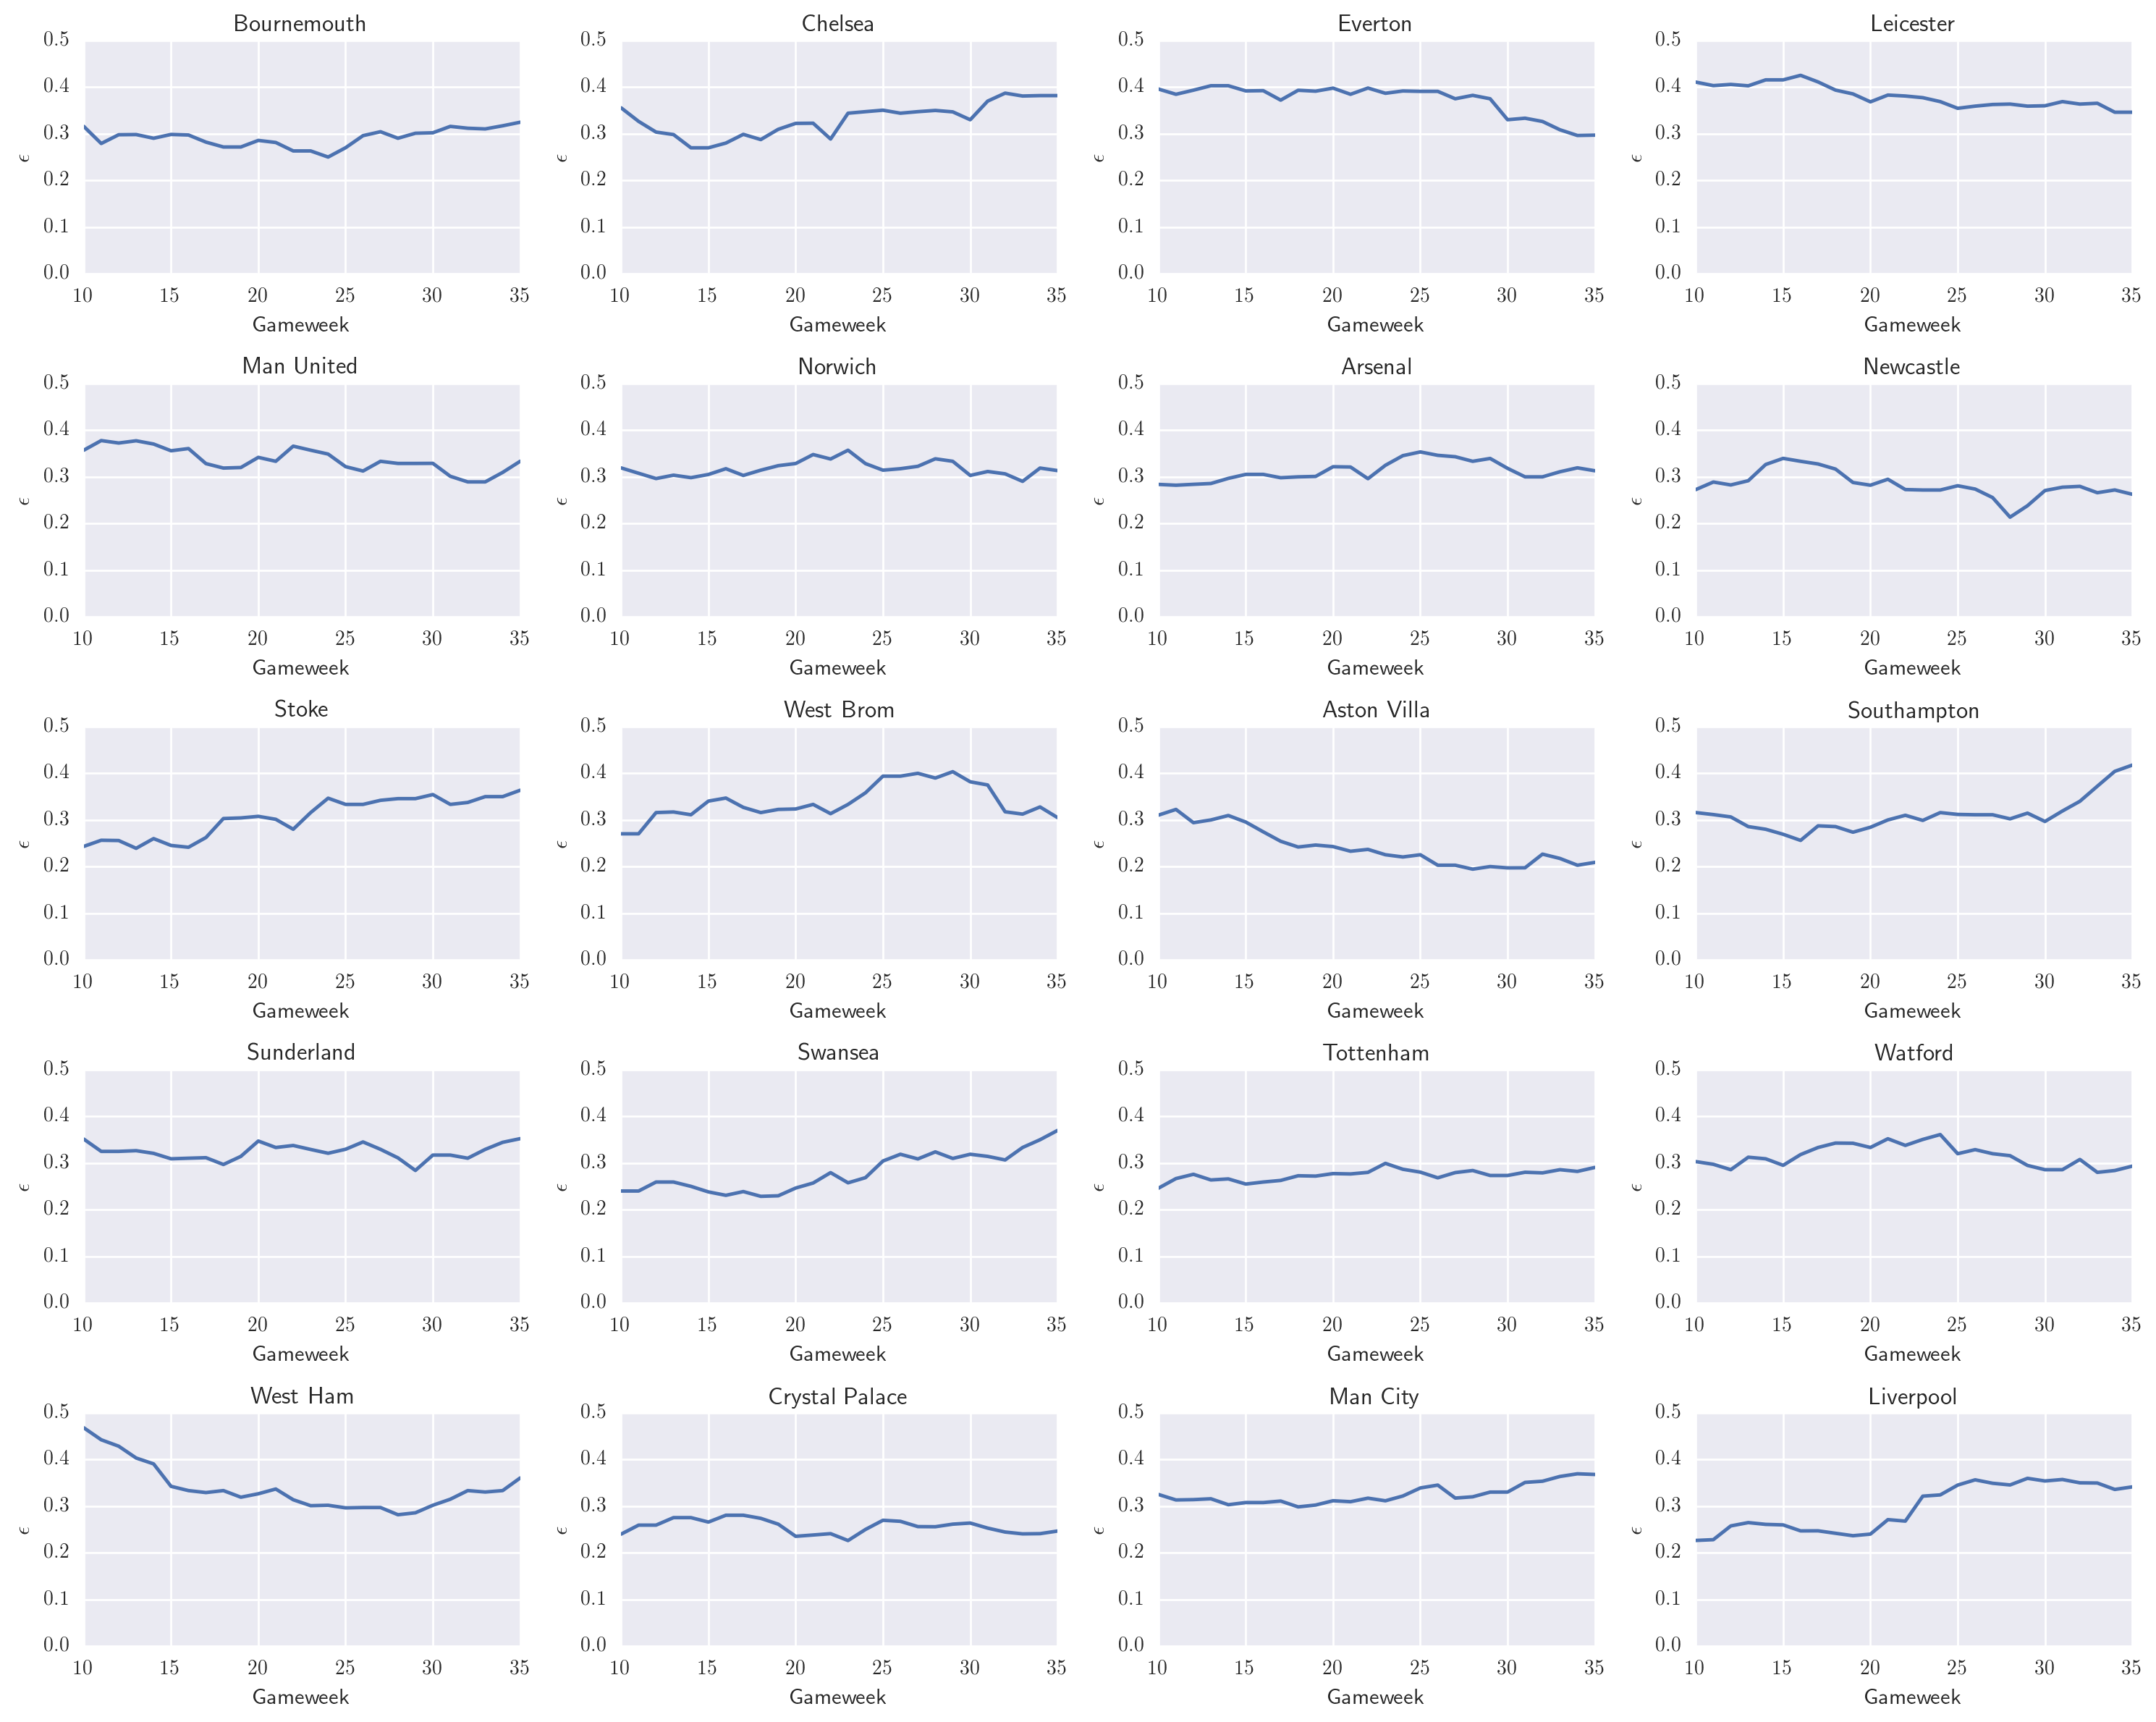

In [19]:
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(epsilon[team][10:])
    np.ravel(ax)[i].set_ylim((0.,.5))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\epsilon$");